In [2]:
%reset -f
# !pip uninstall -y -r requirements.txt

#!pip install tensorflow==2.3
#!pip install albumentations
#!pip install nltk
#!pip install google_trans_new
#!pip install deep-translator

In [63]:
import time
import random
import numpy as np # linear algebra
import pandas as pd

# from google_trans_new import google_translator
# from deep_translator import GoogleTranslator
# from deep_translator import MyMemoryTranslator
# from deep_translator import LingueeTranslator

import os
import sys
import PIL
import cv2
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_ru', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

from catboost import CatBoostRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [64]:
print('Python:        ', sys.version.split('\n')[0])
print('Pandas:       ', pd.__version__)
print('Numpy:        ', np.__version__)
print('Tensorflow:  ', tf.__version__)

Python:         3.7.6 (default, Jan  8 2020, 13:42:34) 
Pandas:        1.0.1
Numpy:         1.18.5
Tensorflow:   2.3.0


In [5]:
RANDOM_SEED = 102
np.random.seed(RANDOM_SEED)
#!pip freeze > 'requirements.txt'

## 1. DATA

In [6]:
######## preprocessing ##############

def join_data(train_input, test_input):
    """ combine train and test data """
    
    train_output = train_input.copy()
    test_output = test_input.copy()
    
    train_output['sample'] = 1 # mark train
    test_output['sample'] = 0 # mark тест
    test_output['price'] = 0 # we must predict it
    data = test_output.append(train_output, sort=False).reset_index(drop=True) # объединяем
    print("Train:", train.shape, "\tTest:", test.shape, "\tdata:", data.shape)
    
    return data


def translate_text(text):
    text = ''.join( re.findall ( "[\sА-Яа-яA-Za-z0-9.,:;!?()-_]+" , text) )
    text = re.sub("\n+", "", text) # remove long spaces        
    text = re.sub("\-+|\_+", " ", text) # symbols - or _ replace with space
    text = re.sub("\.+", ".", text) # many . replace with one .
    text = re.sub("\s+", " ", text).strip() # remove long spaces
    
    if len(text) < 4:  return save_info('-')           
    text = text[:3000].lower() # restrictions by services        

        # translators (5 req / sec | 20k / day)    
    #s = GoogleTranslator().translate(text, lang_src='ru', lang_tgt='en') 
    s = google_translator().translate(text, lang_src='ru', lang_tgt='en') 
    #s = MyMemoryTranslator(source="ru", target="en").translate(text) # 500 smb
    #s = LingueeTranslator().translate(text, lang_src='ru', lang_tgt='en') 

    save_info(s) # save every string step by step
    time.sleep(1) # wait a second - against blocking
    return s


def save_info(s):
    file = open('description_en.csv', "a+")
    file.write(s+'\n')
    file.close()     
    return s


def drop_stopwords(text):
    # remove stop words
    text = text.lower() # ! make a lower case
    STOPWORDS = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text


def base_form(s):    
    """ make a base form for words """    
    s = s.lower() # ! make a lower case
    
    def what_part(tag):
        if tag in ['NN', 'NNS', 'NNP', 'NNPS']: return wordnet.NOUN
        elif tag in ['JJ', 'JJR', 'JJS']: return wordnet.ADJ
        elif tag in ['RB', 'RBR', 'RBS']: return wordnet.ADV
        elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']: return wordnet.VERB
        return wordnet.NOUN

    teokn = word_tokenize(s)
    tags = nltk.pos_tag(teokn, lang='eng')    
    output=''
    for tag in tags:
        output += ' ' + WordNetLemmatizer().lemmatize(tag[0], what_part(tag[1]))           

    return output


def clean_text(text):
    text = re.sub("\d+", "", text) # remove digits
    text = re.sub(r'\s+([?.!,:"])', r'\1', text) # remove space before punctuation    
    text = re.sub(r'[^\w\s]','', text) # remove punctuation
    text = re.sub("\s+", " ", text) # remove long spaces
    return text.strip()

In [7]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'

train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

data = join_data(train, test) # start from scratch
print('Columns:\n', *data.columns, sep='   ')

pd.set_option('display.max_rows', 100) # show more rows
pd.set_option('display.max_columns', 50) # show more columns

Train: (6682, 22) 	Test: (1671, 21) 	data: (8353, 23)
Columns:
   bodyType   brand   color   description   engineDisplacement   enginePower   fuelType   mileage   modelDate   model_info   name   numberOfDoors   productionDate   sell_id   vehicleConfiguration   vehicleTransmission   Владельцы   Владение   ПТС   Привод   Руль   sample   price


In [8]:
# rename columns
cols_dict = {
        'Владельцы': 'owners',
        'Владение': 'ownership',
        'ПТС': 'vhp',
        'Привод': 'gear',
        'Руль': 'wheel'
    }
data.rename(columns=cols_dict, inplace=True)

### 1.2. Nan values

In [9]:
# look at columns with nan
data_nan = data[ data.columns[data.isnull().sum()>0] ]
print(f' \t data\n column  \t    nan \n{ round(data_nan.isna().sum() / data.shape[0] * 100,2)}%')

 	 data
 column  	    nan 
owners        0.01
ownership    64.86
dtype: float64%


In [10]:
# remove column 'ownership': high percent of empty values
data.drop('ownership',  axis=1, inplace=True)

### 1.3. Analyze columns

In [11]:
        # bodyType
display(data[['bodyType', 'numberOfDoors']].head(1))
 # remove info about doors in 'bodyType'
data.loc[:, 'bodyType'] = data.bodyType.apply(lambda x: x.split()[0])

,bodyType,numberOfDoors
0,универсал 5 дв.,5


In [12]:
    # engineDisplacement
#print(' data:', *data.engineDisplacement.unique(), sep='\t') # unique values
 # remove ' LTR'
data.loc[:,'engineDisplacement'] = data.engineDisplacement.str[:3]

# Test part: replace 1 'und' value with "_"
data.loc[ (data['engineDisplacement']=='und') & (data['sample']==0), 'engineDisplacement'] = '-'
 # Train part: drop left 5 'und' values
data = data[ data.engineDisplacement != 'und' ]

# reset index
data.reset_index(drop=True, inplace=True)

In [13]:
        # enginePower
 # remove last for symbols ' N12' and convert to int type
data.enginePower = data.enginePower.str[:-4].astype(int)

In [14]:
    # vehicleConfiguration
# vehicleConfiguration contains the same info as other 3 columns
display( data[['bodyType', 'vehicleTransmission', 'engineDisplacement', 'vehicleConfiguration']].sample(2) )

,bodyType,vehicleTransmission,engineDisplacement,vehicleConfiguration
4006,седан,вариатор,2.0,SEDAN VARIATOR 2.0
5222,седан,автоматическая,3.0,SEDAN AUTOMATIC 3.0


In [15]:
    # owners
data.loc[:, 'owners'] = data.owners.str[0] # take numbers
display(data[ data.owners.isna() ]) # show all owners with nan

 # find a possible value in order to fill the a nan value
n = data.query("model_info=='S8' & productionDate == 2001").owners.dropna().unique()
print('Value for filling: ', *n)
data.owners.fillna(int(n), inplace=True) # fill nan

 # 1 nan in Train part, so drop it
#data.owners.dropna(axis=0, inplace=True)
#data.reset_index(drop=True, inplace=True) # reset index

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,owners,vhp,gear,wheel,sample,price
6662,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2,360,бензин,160000,1999,S8,4.2 AT (360 л.с.) 4WD,4,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,Оригинал,полный,Левый,1,600000.0


Value for filling:  3


In [16]:
        # name
# 'name' contains info from other columns
data[['engineDisplacement', 'vehicleTransmission', 'enginePower',  'gear', 'name' ]].sample(1)

,engineDisplacement,vehicleTransmission,enginePower,gear,name
2918,2.0,роботизированная,211,полный,2.0 AMT (211 л.с.) 4WD


In [17]:
def preproc_text(col):
        # drop stopwords 
    col = col.apply(lambda x: drop_stopwords(x) )
        # make a base form for words
    col= col.apply(lambda x: base_form(x) )
        # clean text
    col = col.apply(lambda x: clean_text(x) )
        # fill nan and empty values
    col.fillna("_", inplace = True)
    col = col.replace('', '_')

    return col
                
 # translate text in 'description' (long time)
# data.loc[:, 'description_en'] = data['description'].apply(lambda x: translate_text(x) )

  # restore from file
data.loc[:, 'description_en'] = pd.read_csv( '../input/mydata/'  + 'description_en.csv', sep='\n' )['description_en']

    # text preprocessing
#data.loc[:, 'description_en'] = preproc_text( data['description_en'] )

 # save cleaned data
#data.to_csv('../input/mydata/'  +  'data_clean.csv', index=False) # save all data

### 1.4. Feature Engineering 

In [18]:
###### new bin features
data = pd.read_csv('../input/mydata/'  +  'data_clean.csv') # load cleaned data
new_bin= set()

def create_bin_features(col_search, words): 
    col_search = col_search.str.lower()
    for el in words:
        el = el.lower()
        new_col_name = el.split('|')[0]
        new_bin.add(new_col_name) 
        data.loc[ col_search.str.contains(el), new_col_name ] = 1
        data[new_col_name].fillna(0, inplace=True)
    return new_bin


word_lst = 'xdrive long|длинный' .split()
create_bin_features(data['name'], word_lst)
word_lst = 'xdrive airbag discount'.split()
create_bin_features(data['description_en'], word_lst)

print('long', data[data.long==1].shape[0], end='\t')
print('xDrive', data[data.xdrive==1].shape[0], end='\t')
print('airbag', data[data.airbag==1].shape[0], end='\t')
print('discount', data[data.discount==1].shape[0], end='\t')

# data.to_csv('../input/mydata/'  +  'data.csv', index=False) # save all data

long 360	xDrive 1045	airbag 591	discount 467	

### 1.5. Divide columns by groups

In [19]:
print(' Object columns:\t', *data.select_dtypes(include = ['object']).columns.tolist(), sep=' | ')
print( ' Numeric columns:\t', *data.select_dtypes(exclude = ['object']).columns.tolist(), sep=' | ')

 Object columns:	 | bodyType | brand | color | description | engineDisplacement | fuelType | model_info | name | vehicleConfiguration | vehicleTransmission | vhp | gear | wheel | description_en
 Numeric columns:	 | enginePower | mileage | modelDate | numberOfDoors | productionDate | sell_id | owners | sample | price | xdrive | long | airbag | discount


<small>'numberOfDoors' move to  categorical features.</small>

In [20]:
# look at number of unique values in object columns
data.select_dtypes(include = ['object']).nunique()

bodyType                  13
brand                      3
color                     16
description             7649
engineDisplacement        48
fuelType                   4
model_info               122
name                     975
vehicleConfiguration     312
vehicleTransmission        4
vhp                        2
gear                       3
wheel                      2
description_en          7516
dtype: int64

In [21]:
def features_groups():
    numerical_features = ['mileage',  'modelDate', 'productionDate', 'enginePower']
    categorical_features = ['engineDisplacement', 'bodyType', 'brand', 'color', 'fuelType', 'model_info', 'numberOfDoors', 'vehicleTransmission', 'owners', 'gear', 'vhp', 'wheel']
    bin_features = list(new_bin)
    new_features = ''
    return numerical_features, categorical_features, bin_features, new_features

numerical_features, categorical_features, bin_features, new_features = features_groups()
print('\t Numerical features:\n', *numerical_features, sep=' | ')
print('\t Categorical features:\n', *categorical_features, sep=' | ')
print('\t Bin features:', *bin_features, sep=' | ')
print('\t New features:', *new_features, sep=' | ')

	 Numerical features:
 | mileage | modelDate | productionDate | enginePower
	 Categorical features:
 | engineDisplacement | bodyType | brand | color | fuelType | model_info | numberOfDoors | vehicleTransmission | owners | gear | vhp | wheel
	 Bin features: | discount | xdrive | long | airbag
	 New features:


## 2. EDA

In [22]:
data = pd.read_csv('../input/mydata/' + 'data.csv')  # load data from file

### 2.1. distribution

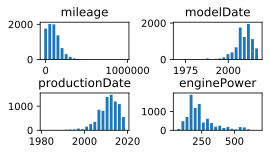

In [23]:
# the distribution of numerical features
def visualize_distributions(titles_values_dict):
  columns = min(2, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 2, rows))
  plt.subplots_adjust(wspace = 0.5, hspace = 0.9)
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': data['mileage'],
    'modelDate': data['modelDate'],
    'productionDate': data['productionDate'], 
     'enginePower': data['enginePower'],
})

The distribution of signs is abnormal, so they need to be normalized.

### 2.2. Correlation

In [24]:
# Pearson correlation for numeric columns
corr = data.loc[:, numerical_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,mileage,modelDate,productionDate,enginePower
mileage,1.000,-0.672,-0.703,-0.185
modelDate,-0.672,1.000,0.965,0.102
productionDate,-0.703,0.965,1.000,0.086
enginePower,-0.185,0.102,0.086,1.000


high correlation have <b>modelDate</b> & <b>productionDate</b>

### 2.3. importance of features

In [25]:
# take a train part
df = data.query('sample == 1').drop(['sample'], axis=1)

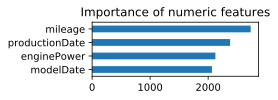

In [26]:
# importance of numeric features

plt.figure(figsize=(3,1))
imp_num = pd.Series(f_regression(df[numerical_features], df['price'])[0],
                 index = numerical_features).sort_values()
imp_num.plot(kind = 'barh')
plt.title('Importance of numeric features')
plt.show()

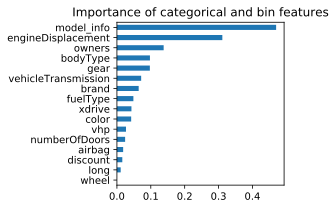

In [27]:
# convert categorical_features
for col in categorical_features:
    df[col] = df[col].astype('category').cat.codes

# importance of categorical and bin
plt.figure(figsize=(3, 3))
mi = mutual_info_regression(df[categorical_features+bin_features], df['price'], discrete_features=True)
pd.Series(mi, index=categorical_features+bin_features).sort_values(ascending=True).plot(kind='barh')
plt.title('Importance of categorical and bin features')
plt.show()

No influence on the 'price' has <b>"wheel"</b>

## 3. Model

In [65]:
data = pd.read_csv('../input/mydata/' + 'data.csv')  # load data from file

In [66]:
######## Preprocessig 

def preproc_data(df_input, drop_cols = [] ): 
    '''includes several functions to pre-process the predictor data.'''    
    df_output = df_input.copy()

    numerical_features = 'mileage modelDate productionDate enginePower'.split()
    categorical_features = 'engineDisplacement bodyType brand color fuelType model_info numberOfDoors vehicleTransmission owners gear vhp wheel'.split()
    bin_features = 'xdrive'.split()
    
     # drop columns     
    df_output.drop('long airbag discount description description_en name sell_id vehicleConfiguration'.split(), axis=1, inplace=True) 
    # remove input features ([] - noting)
    df_output.drop(drop_cols, axis=1, inplace=True) 
    for el in drop_cols: 
        if el in numerical_features:   numerical_features.remove(el)
        if el in categorical_features: categorical_features.remove(el)
        if el in bin_features:              bin_features.remove(el)

    # ################### Numerical Features ##############################################################     
    # Data normalization
    scaler = MinMaxScaler()
    for column in numerical_features:
     # df_output[column] = np.log(df_output[column])
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]

    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)

    return df_output


def data_sepatate(df_preproc):
    """  sepearate data to train and test """    
    train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
    test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

    X = train_data.drop(['price'], axis=1)
    y = train_data.price.values   # target
    X_sub = test_data.drop(['price'], axis=1)    
    print(f'   train_data {train_data.shape} \t\t\t |   test_data {test_data.shape}')
    print(f'\t\tX {X.shape} y {y.shape} \t | \t X_sub {X_sub.shape}')

    return X, y, X_sub


def prep_for_save():
    """ prepatation for saving the checkpoints and configure Earlystopping """
    checkpoint = ModelCheckpoint('../working/' + 'best_model.hdf5' , monitor=['val_MAPE'], verbose=0, mode='min')
    earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
    callbacks_list = [checkpoint, earlystop]
    return callbacks_list


def get_mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) 

# mape scorer: since lesser the error, the better:
my_scorer = make_scorer(get_mape, greater_is_better=False)

def test_mape(y_test, test_predict):
    print(f"TEST mape: { get_mape(y_test, test_predict) * 100:0.2f}%")
    return

def draw_graph(history):
    plt.title('Loss')
    plt.plot(history.history['MAPE'], label='train')
    plt.plot(history.history['val_MAPE'], label='test')
    plt.show();

def save_model(model, model_name='my_model'): 
    model.load_weights('../working/'   +  'best_model.hdf5')
    model.save('../working/' + model_name + '.hdf5')

### 3.0.1. naive model
<small> This model will predict the average price by model and year of production. We will compare other models with it.</small>

In [54]:
# split data to 2 parts
train_data = data.query('sample == 1').drop(['sample'], axis=1)

train_part, test_part = train_test_split(train_data, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# make a naive model
predicts = []
for index, row in pd.DataFrame(test_part[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(train_part.query(query)['price'].median())

# fill in not found matches
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

predicts = (predicts // 1000) * 1000 # round up
test_mape( test_part['price'], predicts.values[:, 0] ) # mape = 17.39

TEST mape: 17.39%


### 3.0.2. CatBoost

In [69]:
preproc = preproc_data(data)
X, y, X_sub = data_sepatate(preproc) # separate data back
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

   train_data (6677, 230) 			 |   test_data (1671, 230)
		X (6677, 229) y (6677,) 	 | 	 X_sub (1671, 229)


In [70]:
model = CatBoostRegressor(verbose = False)

cv = KFold(n_splits=5, shuffle=False) 
parameters = { 'iterations' : [5000],
                         'learning_rate': [0.5, 0.1], 
                         'depth': [2, 4],
                         'l2_leaf_reg': [0.2, 0.5, 1, 3],
                         'eval_metric' : ['MAPE'],
                         'random_seed' : [RANDOM_SEED],
                         'od_wait' : [5000],
                         #'custom_metric' : ['RMSE', 'MAE'],
                         #task_type='GPU',
             }

grid = GridSearchCV(estimator=model, param_grid = parameters, scoring=my_scorer, cv = cv, n_jobs=-1)

In [71]:
grid.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         use_best_model=True,   
         #plot=True
         )

print('Train best score: ', -grid.best_score_)
test_mape(y_test, grid.predict(X_test)) # mape = 12.70

Train best score:  0.1309619122445727
TEST mape: 12.70%


In [74]:
# save into variables for blanding
test_predict_catboost = grid.predict(X_test)
sub_predict_catboost = grid.predict(X_sub)

sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('../working/' +  'catboost_submission.csv', index=False)

### 3.1.1. Simple neural network

In [253]:
df_preproc = preproc_data(data) # preprocessing for all data
X, y, X_sub = data_sepatate(df_preproc) # separate data back
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

   train_data (6677, 230) 			 |   test_data (1671, 230)
		X (6677, 229) y (6677,) 	 | 	 X_sub (1671, 229)


In [279]:
    # build a model
model = Sequential()
model.add(L.Dense(256, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.25))
model.add(L.Dense(1, activation="linear"))

# compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
callbacks_list = prep_for_save()

In [282]:
history = model.fit(X_train, y_train,
                    batch_size = 256,
                    epochs = 500, # train until EarlyStopping stops training
                    validation_data = (X_test, y_test),
                    callbacks = callbacks_list,
                    verbose=0,
                   )
test_mape( y_test, model.predict( X_test)[:,0] ) # MAPE 10.99

TEST mape: 10.86%


In [283]:
test_predict_nn1 = model.predict(X_test)
sub_predict_nn1 = model.predict(X_sub)

sample_submission['price'] = sub_predict_nn1[:, 0]
sample_submission.to_csv('../working/' +  'nn1_submission.csv', index=False)

save_model(model, 'nn_1')

### 3.1.2. feature forwarding

In [279]:
df_preproc = preproc_data(data) # preprocessing for all data
X, y, X_sub = data_sepatate(df_preproc) # separate data back
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

   train_data (6677, 230) 			 |   test_data (1671, 230)
		X (6677, 229) y (6677,) 	 | 	 X_sub (1671, 229)


In [185]:
numerical_features

['mileage', 'modelDate', 'productionDate', 'enginePower']

In [281]:
    # mlp (neural network for tabular data)
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [282]:
        # preprocess this feature as categorical.
col_name =  'mileage'

features = L.Input(shape=[1], name=col_name)
 # Embeddings layers
emb_features = L.Embedding(len(X[col_name].unique().tolist())+1, 20)(features)

 # combine the outputs
combinedInput = L.concatenate([model_mlp.output, L.Flatten()(emb_features),])

 # being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, features], outputs=head)

 # compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
callbacks_list = prep_for_save()

In [283]:
history = model.fit( [X_train, X_train[col_name].values], y_train,
                    batch_size=512,
                    epochs=1500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test[col_name].values], y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )
test_mape( y_test, model.predict( [X_test, X_test.productionDate.values] ) [:,0] ) # MAPE 10.99

TEST mape: 11.20%


### 3.2. Multi-Input Network: Tabular Data + Text

In [44]:
    # preprocess and split all data (not remove 'description_en')
df_preproc = preproc_data(data) # preprocessing for all data
X, y, X_sub = data_sepatate(df_preproc) # separate data back
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

   train_data (6677, 230) 			 |   test_data (1671, 230)
		X (6677, 229) y (6677,) 	 | 	 X_sub (1671, 229)


In [273]:
    # tokenize the text field
col = data['description_en']
MAX_WORDS = 100000 # The maximum number of words to be used. (most frequent)
MAX_SEQUENCE_LENGTH = 256 # Max number of words in each complaint.

 # split 'description_en'  to Train and Test part
text_train = data.description_en.iloc[X_train.index]
text_test = data.description_en.iloc[X_test.index]
text_sub = data.description_en.iloc[X_sub.index]

 # create a dictionary
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts( col )
print('Dictionary:',*list(tokenize.word_index.items())[:5])

 # vectorize the text
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train ), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test ), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub ), maxlen=MAX_SEQUENCE_LENGTH)
print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )
print('original text:', text_train.iloc[0][-20:])
print('vectorized:', *text_train_sequences[0][-20:])

Dictionary: ('car', 1) ('system', 2) ('condition', 3) ('mileage', 4) ('rear', 5)
(5675, 256) (1002, 256) (1671, 256)
original text: dorokhovo inspection
vectorized: 0 0 0 0 0 1 188 929 33 16 65 102 415 215 347 186 98 968 25098 246


In [651]:
    # RNN NLP (neural network for text)
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

In [652]:
    # mlp (neural network for tabular data)
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [653]:
        # Multiple Inputs NN
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
 # being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])
callbacks_list = prep_for_save()

In [654]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=256,
                    epochs=100, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test ], y_test ),
                    callbacks=callbacks_list
                   )

test_mape( y_test, model.predict( [text_test_sequences, X_test] )[:,0] ) # MAPE 11.5

23/23 [==============================] - 131s 6s/step - loss: 99.1527 - MAPE: 99.1527 - val_loss: 92.8543 - val_MAPE: 92.8543


In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test]) # save for blanding
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])

sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv('../working/' +  'nn2_submission.csv', index=False)

### 3.3. Multi-Input Network: Tabular Data + Text + Images

In [55]:
    # preprocess and split all data (not remove 'description_en')
df_preproc = preproc_data(data) # preprocessing for all data
X, y, X_sub = data_sepatate(df_preproc) # separate data back
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

   train_data (6677, 230) 			 |   test_data (1671, 230)
		X (6677, 229) y (6677,) 	 | 	 X_sub (1671, 229)


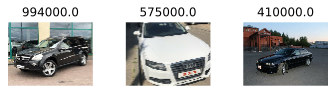

In [56]:
# make sure that the prices and photos are loaded correctly
random_image = train.sample(n=3)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title( str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [57]:
# load these pictures into memory and create a matrix
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5675, 240, 320, 3) dtype uint8
images shape (1002, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


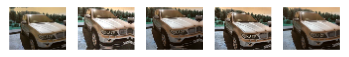

In [59]:
# image augmentation

from albumentations import (
    HorizontalFlip, CLAHE, Rotate, OneOf, Compose, 
    Blur, MotionBlur, GridDistortion, HueSaturationValue,
    GaussNoise, RandomBrightnessContrast, RGBShift, 
    LongestMaxSize, Resize, CenterCrop, ShiftScaleRotate
)

#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    #Resize(width=size[0-10], height=size[1]-10),
    #CenterCrop(width=size[0]-20, height=size[1]-20),
    HorizontalFlip(p=1),
    GaussNoise(),
    OneOf([
        MotionBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1)
    ], p=1),
    ShiftScaleRotate(shift_limit=0.08, scale_limit=0, rotate_limit=3, p=1),    
    RandomBrightnessContrast(brightness_limit=[0.05, 0.1], contrast_limit=[0.05, 0.1] ),
    #  RGBShift(p=0.5),
    OneOf([
        CLAHE(clip_limit=2),
        GridDistortion(p=0.1)
    ], p=0.3), 
    HueSaturationValue(hue_shift_limit=[0,15], p=0.5)
], p=1)

# example
plt.figure(figsize = (6, 4))
for i in range(5):
    img = augmentation(image = images_train[10])['image']
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [60]:
def make_augmentations(images):
  print('apply augmentation', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [61]:
    # use the tokenizer
col = data['description_en']
MAX_WORDS = 100000 # The maximum number of words to be used. (most frequent)
MAX_SEQUENCE_LENGTH = 256 # Max number of words in each complaint.

tokenize = Tokenizer(num_words=100000)
tokenize.fit_on_texts( col )

In [62]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

# check that there are no errors (no exception will be thrown)
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [58]:
        # Picture recognition network
 # use efficientnet without a head
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB7(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

258080768/258076736 [==============================] - 75s 0us/step


In [227]:
# network for analyzing tabular data
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [229]:
    # NLP network for text preprocessing
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [231]:
# combine the outputs of 3 neural networks.
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
#model.summary()

In [232]:
 # set up metrics, 
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])
 # set checkpoints and EarlyStopping,
callbacks_list = prep_for_save()

In [ ]:
history = model.fit(train_dataset.batch(16),
                    epochs=100,
                    validation_data=test_dataset.batch(16),
                    callbacks=callbacks_list
                    )
test_mape( y_test,  model.predict(test_dataset.batch(16))[:,0] ) # MAPE 11.7

In [ ]:
# model.load_weights('../input/models/nn_3.hdf5')
# save_model(model, 'nn_3')

In [237]:
test_predict_nn3 = model.predict(test_dataset.batch(16))
sub_predict_nn3 = model.predict(sub_dataset.batch(16))

sample_submission['price'] = sub_predict_nn3[:, 0]
sample_submission.to_csv('../working/' +  'nn3_submission.csv', index=False)

### 4. Blend

In [127]:
blend_predict = ( test_predict_catboost + test_predict_nn1 [:, 0] ) / 2
test_mape( y_test, blend_predict )

TEST mape: 11.16%


In [131]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:, 0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('../working/' + 'blend_submission.csv', index=False)